In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Pendekatan 2 (Dataset dipisah dari awal)**

In [ ]:
file_path1 = "/content/drive/My Drive/Semester2/DeepLearning/dataset pisah/Dataset.xlsx"
train_df = pd.read_excel(file_path1, sheet_name="training", header = None)
test_df = pd.read_excel(file_path1, sheet_name="testing",header = None)
train_df.columns = ["X1", "X2", "X3", "X4", "Target"]
train_df.insert(0, "X0", 1)
test_df.columns = ["X1", "X2", "X3", "X4", "Target"]
test_df.insert(0, "X0", 1)

In [ ]:
# Preprocessing: Encoding kolom 'object' jika ada pada training data
for column in train_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_df[column] = le.fit_transform(train_df[column])
    if column in test_df.columns:
        test_df[column] = le.transform(test_df[column])

In [ ]:
# inisialisasi kolom tambahan untuk training data
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE",
            "dbias","dteta1","dteta2","dteta3","dteta4"]:
    train_df[col] = 0.0

In [ ]:
# Inisialisasi kolom tambahan untuk testing data (hanya kolom yang diperlukan untuk forward pass dan error)
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE"]:
    test_df[col] = 0.0

In [ ]:
# --- MULAI PROSES TRAINING ---

learning_rate = 0.1
epochs = 5# Menaikkan epoch untuk melihat konvergensi yang lebih baik

# Inisialisasi nilai awal bobot di baris pertama training_df (index 0)
initial_bias  = 0.5
initial_teta1 = 0.5
initial_teta2 = 0.5
initial_teta3 = 0.5
initial_teta4 = 0.5

# Simpan bobot awal ke baris 0 training_df
# Pastikan train_df memiliki setidaknya satu baris untuk loc[0]
if not train_df.empty:
    train_df.loc[0, ["bias","teta1","teta2","teta3","teta4"]] = [initial_bias, initial_teta1, initial_teta2, initial_teta3, initial_teta4]
    train_df.loc[0, ["dbias","dteta1","dteta2","dteta3","dteta4"]] = 0.0 # Gradien awal 0
else:
    print("Warning: Training DataFrame is empty. Cannot initialize weights.")
    exit()

# Variabel untuk menyimpan history loss dan akurasi
training_loss_history = []
testing_loss_history = [] # Nama diubah menjadi testing
training_accuracy_history = []
testing_accuracy_history = [] # Nama diubah menjadi testing

# Loop untuk setiap epoch
for epoch in range(epochs):
    # Inisialisasi bobot untuk epoch saat ini
    if epoch == 0:
        current_bias_epoch  = initial_bias
        current_teta1_epoch = initial_teta1
        current_teta2_epoch = initial_teta2
        current_teta3_epoch = initial_teta3
        current_teta4_epoch = initial_teta4
    else:
        # Ambil bobot final dari epoch sebelumnya (baris terakhir train_df)
        current_bias_epoch  = train_df.loc[len(train_df)-1, "bias"]
        current_teta1_epoch = train_df.loc[len(train_df)-1, "teta1"]
        current_teta2_epoch = train_df.loc[len(train_df)-1, "teta2"]
        current_teta3_epoch = train_df.loc[len(train_df)-1, "teta3"]
        current_teta4_epoch = train_df.loc[len(train_df)-1, "teta4"]

    # Loop untuk setiap baris data training
    for i in range(len(train_df)):
        x0 = train_df.loc[i, "X0"]
        x1 = train_df.loc[i, "X1"]
        x2 = train_df.loc[i, "X2"]
        x3 = train_df.loc[i, "X3"]
        x4 = train_df.loc[i, "X4"]
        target = train_df.loc[i, "Target"]

        if i == 0:
            current_bias  = current_bias_epoch
            current_teta1 = current_teta1_epoch
            current_teta2 = current_teta2_epoch
            current_teta3 = current_teta3_epoch
            current_teta4 = current_teta4_epoch
        else:
            prev_bias  = train_df.loc[i-1, "bias"]
            prev_teta1 = train_df.loc[i-1, "teta1"]
            prev_teta2 = train_df.loc[i-1, "teta2"]
            prev_teta3 = train_df.loc[i-1, "teta3"]
            prev_teta4 = train_df.loc[i-1, "teta4"]

            prev_dbias  = train_df.loc[i-1, "dbias"]
            prev_dteta1 = train_df.loc[i-1, "dteta1"]
            prev_dteta2 = train_df.loc[i-1, "dteta2"]
            prev_dteta3 = train_df.loc[i-1, "dteta3"]
            prev_dteta4 = train_df.loc[i-1, "dteta4"]

            current_bias  = round(prev_bias  - learning_rate * prev_dbias, 4)
            current_teta1 = round(prev_teta1 - learning_rate * prev_dteta1, 4)
            current_teta2 = round(prev_teta2 - learning_rate * prev_dteta2, 4)
            current_teta3 = round(prev_teta3 - learning_rate * prev_dteta3, 4)
            current_teta4 = round(prev_teta4 - learning_rate * prev_dteta4, 4)

        # Simpan bobot yang digunakan untuk baris ini (penting untuk iterasi selanjutnya)
        train_df.loc[i, "bias"]  = current_bias
        train_df.loc[i, "teta1"] = current_teta1
        train_df.loc[i, "teta2"] = current_teta2
        train_df.loc[i, "teta3"] = current_teta3
        train_df.loc[i, "teta4"] = current_teta4

        # Hitung dot product (z)
        dotz = (x0 * current_bias +
                x1 * current_teta1 +
                x2 * current_teta2 +
                x3 * current_teta3 +
                x4 * current_teta4)
        train_df.loc[i, "dotz"] = round(dotz, 4)

        # Hitung nilai Sigmoid (aktivasi)
        sigmoid = 1 / (1 + np.exp(-dotz))
        train_df.loc[i, "sigmoid"] = round(sigmoid, 4)

        # Tentukan Prediksi
        train_df.loc[i, "prediksi"] = 1 if sigmoid > 0.5 else 0

        # Hitung Error dan SSE
        error = sigmoid - target
        train_df.loc[i, "error"] = round(error, 4)
        train_df.loc[i, "SSE"]   = round(error**2, 4)

        # Hitung Gradien
        train_df.loc[i, "dbias"]  = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x0, 6)
        train_df.loc[i, "dteta1"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x1, 6)
        train_df.loc[i, "dteta2"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x2, 6)
        train_df.loc[i, "dteta3"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x3, 6)
        train_df.loc[i, "dteta4"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x4, 6)

    # --- Evaluasi pada Testing Set setelah setiap epoch ---
    # Ambil bobot final dari training epoch ini (bobot dari baris terakhir train_df)
    final_bias_epoch  = train_df.loc[len(train_df)-1, "bias"]
    final_teta1_epoch = train_df.loc[len(train_df)-1, "teta1"]
    final_teta2_epoch = train_df.loc[len(train_df)-1, "teta2"]
    final_teta3_epoch = train_df.loc[len(train_df)-1, "teta3"]
    final_teta4_epoch = train_df.loc[len(train_df)-1, "teta4"]

    # Terapkan bobot ini ke seluruh testing set
    test_df["bias"]  = final_bias_epoch
    test_df["teta1"] = final_teta1_epoch
    test_df["teta2"] = final_teta2_epoch
    test_df["teta3"] = final_teta3_epoch
    test_df["teta4"] = final_teta4_epoch

    # Hitung forward pass untuk testing set
    test_df["dotz"] = (test_df["X0"] * test_df["bias"] +
                      test_df["X1"] * test_df["teta1"] +
                      test_df["X2"] * test_df["teta2"] +
                      test_df["X3"] * test_df["teta3"] +
                      test_df["X4"] * test_df["teta4"])

    test_df["sigmoid"] = 1 / (1 + np.exp(-test_df["dotz"]))
    test_df["prediksi"] = test_df["sigmoid"].apply(lambda x: 1 if x > 0.5 else 0)
    test_df["error"] = test_df["sigmoid"] - test_df["Target"]
    test_df["SSE"]   = test_df["error"]**2

    # --- Hitung dan simpan akurasi ---
    train_accuracy = (train_df["prediksi"] == train_df["Target"]).mean()
    test_accuracy   = (test_df["prediksi"]   == test_df["Target"]).mean()

    training_loss_history.append(train_df['SSE'].mean())
    testing_loss_history.append(test_df['SSE'].mean())
    training_accuracy_history.append(train_accuracy)
    testing_accuracy_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Training SSE P2: {training_loss_history[-1]:.4f} | Testing SSE P2: {testing_loss_history[-1]:.4f} | Training Acc P2: {training_accuracy_history[-1]:.4f} | Testing Acc P2: {testing_accuracy_history[-1]:.4f}")
    # --- CETAK HASIL PADA EPOCH PERTAMA ---
    if epoch == 4:
        print("\n=== HASIL TRAINING SETELAH EPOCH 1 ===")
        print("\nTrain DataFrame:")
        print(train_df.to_string())
        print("\nValidation DataFrame:")
        print(test_df.to_string())
# Tampilkan dataset terakhir setelah semua epoch selesai
print("\n--- TRAINING SELESAI ---")
print("\nFinal Training Dataset:")
print(train_df.to_string())

print("\nFinal Testing Dataset:")
print(test_df.to_string())


Epoch 1/5 | Training SSE P2: 0.4608 | Testing SSE P2: 0.0021 | Training Acc P2: 0.5125 | Testing Acc P2: 1.0000
Epoch 2/5 | Training SSE P2: 0.0360 | Testing SSE P2: 0.0022 | Training Acc P2: 0.9625 | Testing Acc P2: 1.0000
Epoch 3/5 | Training SSE P2: 0.0238 | Testing SSE P2: 0.0023 | Training Acc P2: 0.9750 | Testing Acc P2: 1.0000
Epoch 4/5 | Training SSE P2: 0.0171 | Testing SSE P2: 0.0024 | Training Acc P2: 0.9875 | Testing Acc P2: 1.0000
Epoch 5/5 | Training SSE P2: 0.0128 | Testing SSE P2: 0.0023 | Training Acc P2: 0.9875 | Testing Acc P2: 1.0000

=== HASIL TRAINING SETELAH EPOCH 1 ===

Train DataFrame:
    X0   X1   X2   X3   X4  Target    bias   teta1   teta2   teta3   teta4    dotz  sigmoid  prediksi   error     SSE     dbias    dteta1    dteta2    dteta3    dteta4
0    1  5.1  3.5  1.4  0.2       0  0.2724 -0.2361 -0.3417  1.0119  0.7780 -0.5554   0.3646       0.0  0.3646  0.1329  0.168940  0.861592  0.591289  0.236516  0.033788
1    1  4.9  3.0  1.4  0.2       0  0.2555 -0.

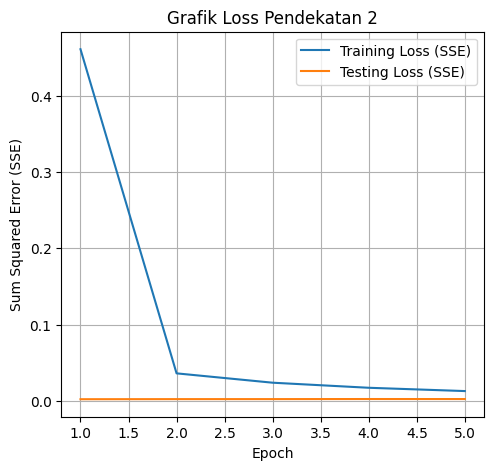

In [ ]:
# --- PLOTTING FUNGSI LOSS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot pertama
plt.plot(range(1, epochs + 1), training_loss_history, label='Training Loss (SSE)')
plt.plot(range(1, epochs + 1), testing_loss_history, label='Testing Loss (SSE)')
plt.title('Grafik Loss Pendekatan 2')
plt.xlabel('Epoch')
plt.ylabel('Sum Squared Error (SSE)')
plt.legend()
plt.grid(True)


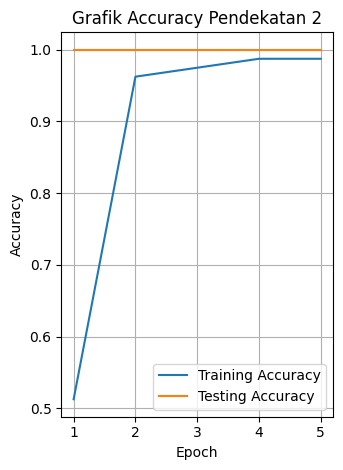

In [ ]:
# --- PLOTTING FUNGSI AKURASI ---
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot kedua
plt.plot(range(1, epochs + 1), training_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), testing_accuracy_history, label='Testing Accuracy') # Label diubah
plt.title('Grafik Accuracy Pendekatan 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Pendekatan 3 (train-validation split)**

In [ ]:
file_path2 = "/content/drive/My Drive/Semester2/DeepLearning/Dataset1.xlsx"
dataset1 = pd.read_excel(file_path2, header=None)
dataset1.columns = ["X1", "X2", "X3", "X4", "Target"]
dataset1.insert(0, "X0", 1)


In [ ]:
# inisialisasi kolom
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE",
            "dbias","dteta1","dteta2","dteta3","dteta4"]:
    dataset1[col] = 0.0

In [ ]:
# Preprocessing: Encoding kolom 'object' jika ada
for column in dataset1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset1[column] = le.fit_transform(dataset1[column])

In [ ]:
dataset1

,X0,X1,X2,X3,X4,Target,bias,teta1,teta2,teta3,...,dotz,sigmoid,prediksi,error,SSE,dbias,dteta1,dteta2,dteta3,dteta4
0,1,5.1,3.5,1.4,0.2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4.9,3.0,1.4,0.2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,4.7,3.2,1.3,0.2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4.6,3.1,1.5,0.2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5.0,3.6,1.4,0.2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,5.7,3.0,4.2,1.2,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1,5.7,2.9,4.2,1.3,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1,6.2,2.9,4.3,1.3,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1,5.1,2.5,3.0,1.1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = dataset1[["X0", "X1", "X2", "X3", "X4"]]
y = dataset1["Target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df   = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

In [ ]:
# inisialisasi kolom tambahan untuk training data
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE",
            "dbias","dteta1","dteta2","dteta3","dteta4"]:
    train_df[col] = 0.0
# Inisialisasi kolom tambahan untuk validation data (hanya kolom yang diperlukan untuk forward pass dan error)
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE"]:
    val_df[col] = 0.0

In [ ]:
# --- MULAI PROSES TRAINING ---

learning_rate = 0.1
epochs = 5
# Inisialisasi nilai awal bobot di baris pertama training_df (index 0)
initial_bias  = 0.5
initial_teta1 = 0.5
initial_teta2 = 0.5
initial_teta3 = 0.5
initial_teta4 = 0.5

# Simpan bobot awal ke baris 0 training_df
train_df.loc[0, ["bias","teta1","teta2","teta3","teta4"]] = [initial_bias, initial_teta1, initial_teta2, initial_teta3, initial_teta4]
train_df.loc[0, ["dbias","dteta1","dteta2","dteta3","dteta4"]] = 0.0

# Variabel untuk menyimpan history loss
training_loss_history = []
validation_loss_history = []
training_accuracy_history = []
validation_accuracy_history = []

# Loop untuk setiap epoch
for epoch in range(epochs):
    #print(f"\n--- EPOCH {epoch+1}/{epochs} ---")

    # Inisialisasi bobot untuk epoch saat ini
    if epoch == 0:
        current_bias_epoch  = initial_bias
        current_teta1_epoch = initial_teta1
        current_teta2_epoch = initial_teta2
        current_teta3_epoch = initial_teta3
        current_teta4_epoch = initial_teta4
    else:
        current_bias_epoch  = train_df.loc[len(train_df)-1, "bias"]
        current_teta1_epoch = train_df.loc[len(train_df)-1, "teta1"]
        current_teta2_epoch = train_df.loc[len(train_df)-1, "teta2"]
        current_teta3_epoch = train_df.loc[len(train_df)-1, "teta3"]
        current_teta4_epoch = train_df.loc[len(train_df)-1, "teta4"]

    # Loop untuk setiap baris data training
    for i in range(len(train_df)):
        x0 = train_df.loc[i, "X0"]
        x1 = train_df.loc[i, "X1"]
        x2 = train_df.loc[i, "X2"]
        x3 = train_df.loc[i, "X3"]
        x4 = train_df.loc[i, "X4"]
        target = train_df.loc[i, "Target"]

        if i == 0:
            current_bias  = current_bias_epoch
            current_teta1 = current_teta1_epoch
            current_teta2 = current_teta2_epoch
            current_teta3 = current_teta3_epoch
            current_teta4 = current_teta4_epoch
        else:
            prev_bias  = train_df.loc[i-1, "bias"]
            prev_teta1 = train_df.loc[i-1, "teta1"]
            prev_teta2 = train_df.loc[i-1, "teta2"]
            prev_teta3 = train_df.loc[i-1, "teta3"]
            prev_teta4 = train_df.loc[i-1, "teta4"]

            prev_dbias  = train_df.loc[i-1, "dbias"]
            prev_dteta1 = train_df.loc[i-1, "dteta1"]
            prev_dteta2 = train_df.loc[i-1, "dteta2"]
            prev_dteta3 = train_df.loc[i-1, "dteta3"]
            prev_dteta4 = train_df.loc[i-1, "dteta4"]

            current_bias  = round(prev_bias  - learning_rate * prev_dbias, 4)
            current_teta1 = round(prev_teta1 - learning_rate * prev_dteta1, 4)
            current_teta2 = round(prev_teta2 - learning_rate * prev_dteta2, 4)
            current_teta3 = round(prev_teta3 - learning_rate * prev_dteta3, 4)
            current_teta4 = round(prev_teta4 - learning_rate * prev_dteta4, 4)

        # Simpan bobot yang digunakan untuk baris ini (penting untuk iterasi selanjutnya)
        train_df.loc[i, "bias"]  = current_bias
        train_df.loc[i, "teta1"] = current_teta1
        train_df.loc[i, "teta2"] = current_teta2
        train_df.loc[i, "teta3"] = current_teta3
        train_df.loc[i, "teta4"] = current_teta4

        # Hitung dot product (z)
        dotz = (x0 * current_bias +
                x1 * current_teta1 +
                x2 * current_teta2 +
                x3 * current_teta3 +
                x4 * current_teta4)
        train_df.loc[i, "dotz"] = round(dotz, 4)

        # Hitung nilai Sigmoid (aktivasi)
        sigmoid = 1 / (1 + np.exp(-dotz))
        train_df.loc[i, "sigmoid"] = round(sigmoid, 4)

        # Tentukan Prediksi
        train_df.loc[i, "prediksi"] = 1 if sigmoid > 0.5 else 0

        # Hitung Error dan SSE
        error = sigmoid - target
        train_df.loc[i, "error"] = round(error, 4)
        train_df.loc[i, "SSE"]   = round(error**2, 4)

        # Hitung Gradien
        train_df.loc[i, "dbias"]  = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x0, 6)
        train_df.loc[i, "dteta1"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x1, 6)
        train_df.loc[i, "dteta2"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x2, 6)
        train_df.loc[i, "dteta3"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x3, 6)
        train_df.loc[i, "dteta4"] = round(2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x4, 6)

    # --- Evaluasi pada Validation Set setelah setiap epoch ---
    final_bias_epoch  = train_df.loc[len(train_df)-1, "bias"]
    final_teta1_epoch = train_df.loc[len(train_df)-1, "teta1"]
    final_teta2_epoch = train_df.loc[len(train_df)-1, "teta2"]
    final_teta3_epoch = train_df.loc[len(train_df)-1, "teta3"]
    final_teta4_epoch = train_df.loc[len(train_df)-1, "teta4"]

    # Terapkan bobot ini ke seluruh validation set
    val_df["bias"]  = final_bias_epoch
    val_df["teta1"] = final_teta1_epoch
    val_df["teta2"] = final_teta2_epoch
    val_df["teta3"] = final_teta3_epoch
    val_df["teta4"] = final_teta4_epoch

    # Hitung forward pass untuk validation set
    val_df["dotz"] = (val_df["X0"] * val_df["bias"] +
                      val_df["X1"] * val_df["teta1"] +
                      val_df["X2"] * val_df["teta2"] +
                      val_df["X3"] * val_df["teta3"] +
                      val_df["X4"] * val_df["teta4"])

    val_df["sigmoid"] = 1 / (1 + np.exp(-val_df["dotz"]))
    val_df["prediksi"] = val_df["sigmoid"].apply(lambda x: 1 if x > 0.5 else 0)
    val_df["error"] = val_df["sigmoid"] - val_df["Target"]
    val_df["SSE"]   = val_df["error"]**2

    # Simpan rata-rata SSE untuk epoch ini
    training_loss_history.append(train_df['SSE'].mean())
    validation_loss_history.append(val_df['SSE'].mean())

    # Hitung akurasi train & val
    train_accuracy = (train_df["prediksi"] == train_df["Target"]).mean()
    val_accuracy   = (val_df["prediksi"] == val_df["Target"]).mean()
    training_accuracy_history.append(train_accuracy)
    validation_accuracy_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Training Loss SSE P3: {training_loss_history[-1]:.4f} | Validation  Loss SSE P3: {validation_loss_history[-1]:.4f} | "
          f"Train Acc P3: {train_accuracy:.4f} | Val Acc P3: {val_accuracy:.4f}")

print("\n--- TRAINING SELESAI ---")
print("\nFinal Training Dataset:")
print(train_df.to_string())

print("\nFinal Validation Dataset:")
print(val_df.to_string())

Epoch 1/5 | Training Loss SSE P3: 0.4391 | Validation  Loss SSE P3: 0.1456 | Train Acc P3: 0.5125 | Val Acc P3: 0.8500
Epoch 2/5 | Training Loss SSE P3: 0.0571 | Validation  Loss SSE P3: 0.0264 | Train Acc P3: 0.9875 | Val Acc P3: 1.0000
Epoch 3/5 | Training Loss SSE P3: 0.0185 | Validation  Loss SSE P3: 0.0121 | Train Acc P3: 1.0000 | Val Acc P3: 1.0000
Epoch 4/5 | Training Loss SSE P3: 0.0115 | Validation  Loss SSE P3: 0.0074 | Train Acc P3: 1.0000 | Val Acc P3: 1.0000
Epoch 5/5 | Training Loss SSE P3: 0.0084 | Validation  Loss SSE P3: 0.0052 | Train Acc P3: 1.0000 | Val Acc P3: 1.0000

--- TRAINING SELESAI ---

Final Training Dataset:
    X0   X1   X2   X3   X4  Target    bias   teta1   teta2   teta3   teta4    dotz  sigmoid  prediksi   error     SSE     dbias    dteta1    dteta2    dteta3    dteta4
0    1  5.7  2.8  4.5  1.3       1  0.2281 -0.4304 -0.7430  1.4161  0.9408  3.2899   0.9641       1.0 -0.0359  0.0013 -0.002488 -0.014180 -0.006965 -0.011194 -0.003234
1    1  5.6  3.0  

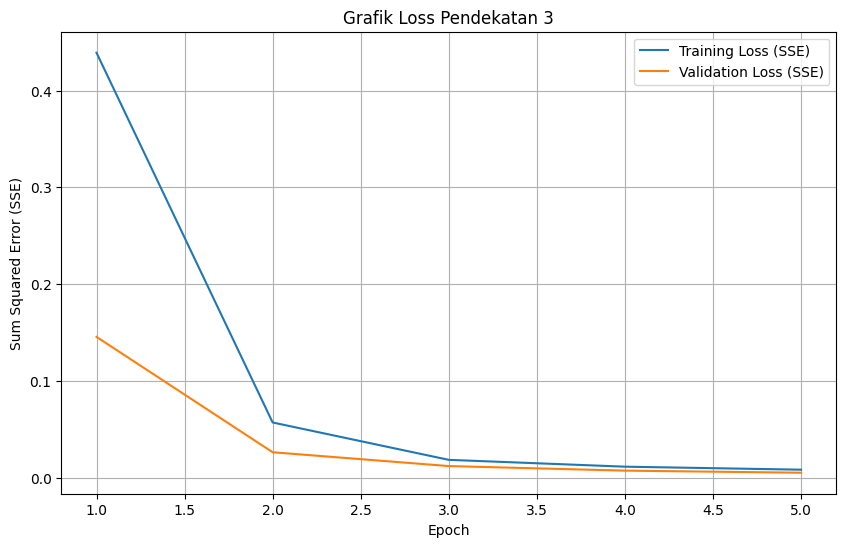

In [ ]:
# --- PLOTTING FUNGSI LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_loss_history, label='Training Loss (SSE)')
plt.plot(range(1, epochs + 1), validation_loss_history, label='Validation Loss (SSE)')
plt.title('Grafik Loss Pendekatan 3')
plt.xlabel('Epoch')
plt.ylabel('Sum Squared Error (SSE)')
plt.legend()
plt.grid(True)
plt.show()

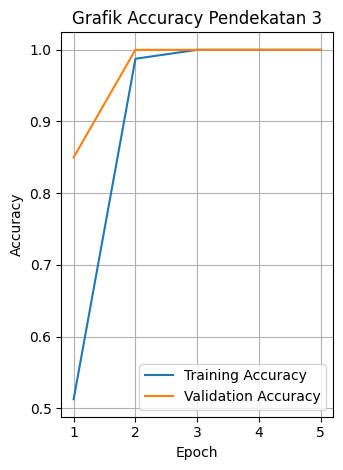

In [ ]:
# --- PLOTTING FUNGSI AKURASI ---
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot kedua
plt.plot(range(1, epochs + 1), training_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_history, label='Validation Accuracy')
plt.title('Grafik Accuracy Pendekatan 3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()